## Нейронный движок игры

деволтный ган, преобразованный из gan_v2

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

    
def plot_samples_on_epoch(samples, nrow=8, chanels=3, size=(8,8)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
        
def see_plot(pict, size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(pict,cmap='gray') #, cmap=color, color='gray'
    plt.grid()
    plt.show()

def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]
#----------------------------------------------------------------------------------------------------
        
# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

torch_version: 1.8.1+cu102,
torchvision_version: 0.8.1
device: cuda:0


## Data

In [2]:
df = pd.read_csv('/media/laggg/surviv_rl_data/dataset_for_moving.csv')
dg = pd.read_csv('/media/laggg/surviv_rl_data/dataset_inventory_v2.csv')
m = []
d = []
for i in range(len(os.listdir('/media/laggg/surviv_rl_data/pickles'))):
    x = os.listdir('/media/laggg/surviv_rl_data/pickles')[i]
    name = x.split('.pi')[0]
    new_d = pickle.load(open("/media/laggg/surviv_rl_data/pickles/{}.pickle".format(name), "rb"))
    m.extend([new_d['mode']]*len(dg[dg.video == name]))
    d.extend(df[df.video == name].target.values.tolist())
dg['mode'] = np.array(m).astype(np.uint8)
dg['dir'] = np.array(d).astype(np.uint8)
dg = dg[dg['dir'] != 0] # убираем все кадры, где игрок стоит на месте (направление 0)

print(dg.shape)
#====================data split==============================================
videos = os.listdir('/media/laggg/surviv_rl_data/all_videoframes_gray/')
v_train, v_val = train_test_split(videos, test_size=0.1, random_state=42)

dg['train'] = dg['video'].apply(lambda x: 1 if x not in v_val else 0)
df_train = dg[dg['train'] == 1]
df_val = dg[dg['train'] == 0]
#============================================================================

print(dg.shape, df_train.shape, df_val.shape)
print('train:', np.unique(df_train['dir'], return_counts=True))
print('val:', np.unique(df_val['dir'], return_counts=True))

(1007275, 25)
(1007275, 26) (910423, 26) (96852, 26)
train: (array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([115934,  96577, 141013,  98032, 115612, 104709, 139067,  99479]))
val: (array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([13250, 10785, 15517,  9819, 11770, 10280, 14523, 10908]))


In [3]:
df_train = df_train.reset_index().drop(['index'], axis=1)
df_val = df_val.reset_index().drop(['index'], axis=1)

def make_dataset(df):
    s = df['dir'].values
    f = df['frame'].values
    zoom = df['zoom'].values
    n_seq = []
    f_seq = []
    n_max = []
    n = 0
    seq = []
    temp_seq = [0]
    a = s[0]
    for i in range(1,len(s)):
        x = s[i]
        if x == a and f[i-1]+1==f[i] and zoom[i]==1:
            temp_seq.append(i)
        else:
            if len(temp_seq)>=5:
                seq.append(temp_seq)
                n_seq.extend([n]*len(temp_seq[:-2]))
                f_seq.extend(temp_seq[:-2])
                n_max.extend([j for j in range(len(temp_seq[:-1]),1,-1)])
                n+=1
            temp_seq = [i]
            a = s[i]

    d = pd.DataFrame({'n_seq': n_seq, 'idx_seq': f_seq, 'n_max': n_max})
    #print(len(seq), len(d))
    return d, seq

d_train, seq = make_dataset(df_train)
d_val, _ = make_dataset(df_val)

## Instead of Data (for collaborators)

In [4]:
#df_train.to_csv('df_train.csv', index=False)
#df_val.to_csv('df_val.csv', index=False)
#d_train.to_csv('d_train.csv', index=False)
#d_val.to_csv('d_val.csv', index=False)

#df_train = pd.read_csv('df_train.csv')
#df_val = pd.read_csv('df_val.csv')
#d_train = pd.read_csv('d_train.csv') #.head(128)
#d_val = pd.read_csv('d_val.csv') #.head(128)

## DataLoader

In [5]:
def apply_aug(p0, aug):
    if aug == 0:
        p = p0.copy()
    elif aug == 1:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
    elif aug == 2:
        p = cv2.rotate(p0, cv2.ROTATE_180)
    elif aug == 3:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif aug == 4:
        p = cv2.flip(p0, 1)
    elif aug == 5:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
        p = cv2.flip(p, 1)
    elif aug == 6:
        p = cv2.rotate(p0, cv2.ROTATE_180)
        p = cv2.flip(p, 1)
    elif aug == 7:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
        p = cv2.flip(p, 1)
    return p


class Surviv_Dataset(Dataset):
    def __init__(self,
                 dataset,
                 df,
                 augs=None):
        super().__init__()
        self.dataset = dataset
        self.df = df
        self.augs = augs
        self.dir_aug = np.array([[0,1,2,3,4,5,6,7,8], # real image
                                 [0,3,4,5,6,7,8,1,2], # rotate 90 o'clock
                                 [0,5,6,7,8,1,2,3,4], # rotate 180    
                                 [0,7,8,1,2,3,4,5,6], # rotate 270
                                 [0,1,8,7,6,5,4,3,2], # real image + gor flip
                                 [0,7,6,5,4,3,2,1,8], # rotate 90 o'clock + gor flip
                                 [0,5,4,3,2,1,8,7,6], # rotate 180 + gor flip
                                 [0,3,2,1,8,7,6,5,4]]) # rotate 270 + gor flip
  
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        i = self.dataset[idx][1]
        n = min(14,np.random.randint(2,self.dataset[idx][2]+2))
        m = np.random.randint(1,n)
        s0 = load_image(self.df[i][0], self.df[i][2])
        s1 = load_image(self.df[i+n][0], self.df[i+n][2])
        _dir = self.df[i][24]
        sp = torch.tensor(self.df[i][4])/100
        zoom = torch.tensor(self.df[i][17])/15
        
        aug = np.random.choice(np.arange(8), p=np.array([0.125]*8))
        _dir = self.dir_aug[aug,_dir]
        s0 = apply_aug(s0, aug)
        s1 = apply_aug(s1, aug)
        
        if self.augs is not None:
            s0 = self.augs(image=s0)['image']
            s1 = self.augs(image=s1)['image']
        
        _dir = F.one_hot(torch.tensor(_dir-1), num_classes=8).float()
        _dir = torch.cat([_dir,sp.unsqueeze(0),zoom.unsqueeze(0)])
        
        return s0, s1, _dir, torch.tensor(n).unsqueeze(0), torch.tensor(m).unsqueeze(0)

## Model

In [6]:
# Generator
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1) # (bath,10+1) --> (batch,512)
        
    def forward(self, inp):

        noise = torch.normal(mean=0.0, std=1.0, size=inp[0].size()).to(params['DEVICE'])
        x_original = self.conv_original_size0(noise) #inp[0]
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(inp[0])            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        #cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2)) # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4) #+cond
        
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)
        
        return out
    
# Discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(6, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1)
        self.conv4_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(4608+11, 1)
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, inp):
        x = F.leaky_relu(self.conv0(inp[0]), 0.2)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = self.conv4_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = torch.cat([x, inp[1]], dim=1)
        x = self.fc(x)
        return x

In [7]:
# GAN loss
Loss = nn.BCEWithLogitsLoss()

def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

#-----------------------------------------
# for perceptual loss
class VGG_for_pl(nn.Module):
    
    def __init__(self, chosen_features=[0,5,10,19,28]):
        super().__init__()
        self.model = models.vgg19(pretrained=True).features
        self.chosen_features = chosen_features
        self.model_parts = []
        prev_layer = self.chosen_features[0]
        for i in range(len(self.chosen_features)):
            curr_layer = self.chosen_features[i]+1
            #print(prev_layer, curr_layer) #[0 1]; [1 6]; [6 11]; [11 20]; [20 29]
            self.model_parts.append(nn.Sequential(*(list(self.model.children())[prev_layer:curr_layer])))
            prev_layer = curr_layer
            
    def forward(self, x):
        features = []
        for part in self.model_parts:
            x = part(x)
            features.append(x)
        return features

In [8]:
train_d_loss_ts = []
train_g_loss_ts = []
train_pl_loss_ts = []
train_pix_loss_ts = []
val_pix_loss_ts = []

  
def train_model(D, G,
                train_iterator, val_iterator,
                loss_func,
                disc_opt, gen_opt,
                params):
    
    best_loss = 1000
    VGG = VGG_for_pl().to(params['DEVICE']).eval()
    MSE = nn.MSELoss()
    
    for i in range(params['EPOCHS']):
        time.sleep(0.2)
        D.train(True)
        G.train(True)
        
        #===========TRAIN====================================================================
        train_d_loss = 0.0
        train_g_loss = 0.0
        train_pl_loss = 0.0
        train_pix_loss = 0.0     
        for x in enumerate(tqdm(train_iterator)): #tqdm(train_iterator)
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2]
            n = x[1][3]/14
            m = x[1][4]/14
            _dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
            _dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
            _dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])
            
            #------------Discriminator training-----------------------
            disc_opt.zero_grad()
            real_out = D((torch.cat([target, target], dim=1),_dir1))
            prediction1 = G((img,_dir1)).detach()
            prediction2 = G((G((img,_dir2)),_dir3)).detach()
            fake_out1 = D((torch.cat([prediction1, prediction1], dim=1),_dir1)) # img
            fake_out2 = D((torch.cat([prediction2, prediction2], dim=1),_dir1)) # img
            d_loss_curr = (discriminator_loss(real_out, fake_out1)\
                         +discriminator_loss(real_out, fake_out2))/2
            train_d_loss += d_loss_curr.item()   # D loss 1/1
            d_loss_curr.backward()
            disc_opt.step()
            #---------------------------------------------------------
            
            #------------Generator training---------------------------
            gen_opt.zero_grad()
            prediction1 = G((img,_dir1))
            prediction2 = G((G((img,_dir2)),_dir3))
            gen_disc_out1 = D((torch.cat([prediction1, prediction1], dim=1),_dir1)) # img
            gen_disc_out2 = D((torch.cat([prediction2, prediction2], dim=1),_dir1)) # img
            g_loss_curr = (generator_loss(gen_disc_out1)+generator_loss(gen_disc_out2))/2      
            pix_loss_curr = (loss_func(prediction1, target)+loss_func(prediction2, target))/2
            #---PL-LOSS--------
            pl_loss_curr = torch.tensor(0.0).float()
            #target_f = VGG(target)
            #pred1_f = VGG(prediction1)
            #pred2_f = VGG(prediction2)
            #for ii in range(len(target_f)):
            #    pl_loss_curr = pl_loss_curr + MSE(pred1_f[ii], target_f[ii].detach())+\
            #                                  MSE(pred2_f[ii], target_f[ii].detach())
            #------------------
            train_g_loss += g_loss_curr.item()     # G loss 1/3
            train_pl_loss += pl_loss_curr.item()   # G loss 2/3
            train_pix_loss += pix_loss_curr.item() # G loss 3/3
            gen_loss_total = g_loss_curr #+ 10*pix_loss_curr + pl_loss_curr/100
            gen_loss_total.backward()
            gen_opt.step()
            #---------------------------------------------------------
            
        train_d_loss_ts.append(round(train_d_loss / len(train_iterator),4))
        train_g_loss_ts.append(round(train_g_loss / len(train_iterator),4))
        train_pl_loss_ts.append(round(train_pl_loss / len(train_iterator),4))
        train_pix_loss_ts.append(round(train_pix_loss / len(train_iterator),4))

        torch.save(G.state_dict(), 'surviv_dcgan_{}e.pth'.format(i+1))         
        
        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'train_Dgan:', train_d_loss_ts[-1],   '|',
              'train_Ggan:', train_g_loss_ts[-1],   '|',
              'train_PL:',   train_pl_loss_ts[-1],  '|',
              'train_pix:',  train_pix_loss_ts[-1])

## First Training

In [9]:
params = {'EPOCHS': 10,
          'DEVICE': 'cuda:0',
          'BATCH': 32}

train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                       ToTensorV2(transpose_mask=False),
                      ])
train_data = Surviv_Dataset(d_train.sample(frac=0.25).values, df_train.values, train_aug) #.head(128)
train_dataloader = DataLoader(train_data, batch_size=params['BATCH'], shuffle=True)
test_data = Surviv_Dataset(d_val.values, df_val.values, train_aug) #.head(128)
test_dataloader = DataLoader(test_data, batch_size=params['BATCH'], shuffle=True)

G = ResNetUNet(n_class=3).to(params['DEVICE'])
D = Discriminator().to(params['DEVICE'])

loss_fn = nn.L1Loss()
disc_opt = optim.Adam(D.parameters(), lr = 0.00005, betas = (0.6, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.6, 0.999))

train_model(D, G,
            train_dataloader, test_dataloader,
            loss_fn,
            disc_opt, gen_opt,
            params) # 3:15

100%|██████████| 716/716 [05:04<00:00,  2.35it/s]


1/10 train_Dgan: 0.9755 | train_Ggan: 1.2327 | train_PL: 0.0 | train_pix: 0.4671


100%|██████████| 716/716 [05:09<00:00,  2.31it/s]


2/10 train_Dgan: 0.6654 | train_Ggan: 1.7219 | train_PL: 0.0 | train_pix: 0.5051


100%|██████████| 716/716 [05:10<00:00,  2.31it/s]


3/10 train_Dgan: 0.7301 | train_Ggan: 1.6905 | train_PL: 0.0 | train_pix: 0.4413


100%|██████████| 716/716 [05:10<00:00,  2.30it/s]


4/10 train_Dgan: 0.6833 | train_Ggan: 1.9704 | train_PL: 0.0 | train_pix: 0.4112


100%|██████████| 716/716 [05:11<00:00,  2.30it/s]


5/10 train_Dgan: 0.741 | train_Ggan: 1.609 | train_PL: 0.0 | train_pix: 0.3285


100%|██████████| 716/716 [05:11<00:00,  2.30it/s]


6/10 train_Dgan: 0.5735 | train_Ggan: 1.9577 | train_PL: 0.0 | train_pix: 0.3144


100%|██████████| 716/716 [05:11<00:00,  2.30it/s]


7/10 train_Dgan: 0.5065 | train_Ggan: 2.1471 | train_PL: 0.0 | train_pix: 0.3298


100%|██████████| 716/716 [05:12<00:00,  2.29it/s]


8/10 train_Dgan: 0.4596 | train_Ggan: 2.4135 | train_PL: 0.0 | train_pix: 0.3503


100%|██████████| 716/716 [05:12<00:00,  2.29it/s]


9/10 train_Dgan: 0.311 | train_Ggan: 2.8777 | train_PL: 0.0 | train_pix: 0.3537


100%|██████████| 716/716 [05:12<00:00,  2.29it/s]


10/10 train_Dgan: 0.4958 | train_Ggan: 2.5445 | train_PL: 0.0 | train_pix: 0.3596


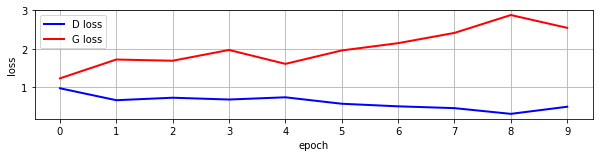

In [20]:
plt.figure(figsize=(10,2));
plt.plot(train_d_loss_ts, color='blue', label='D loss', linewidth=2)
plt.plot(train_g_loss_ts, color='red', label='G loss', linewidth=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(10))
plt.legend()
plt.grid()
plt.show();

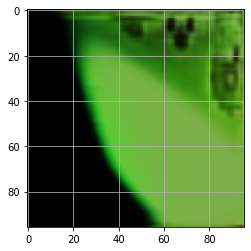

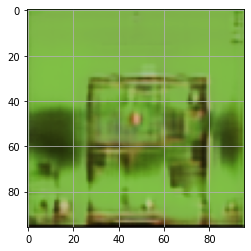

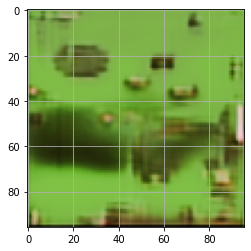

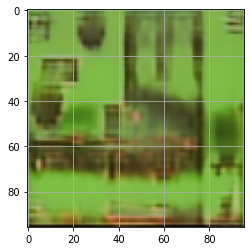

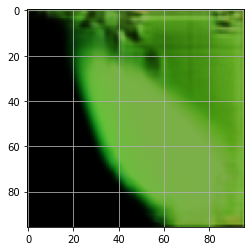

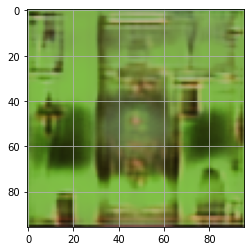

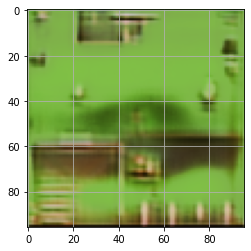

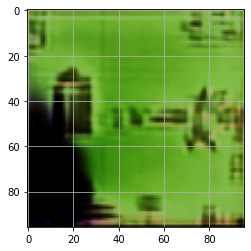

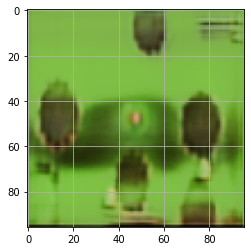

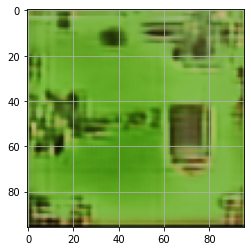

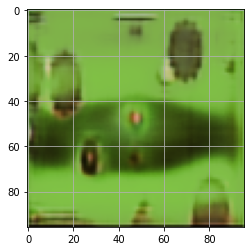

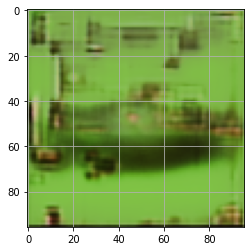

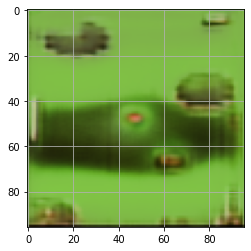

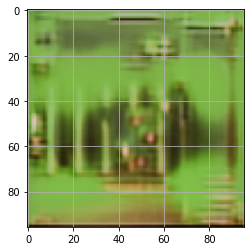

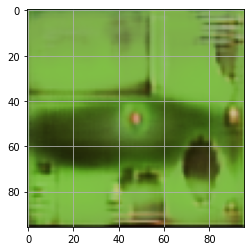

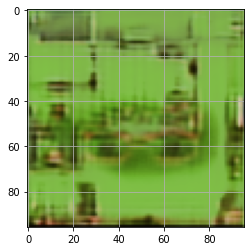

In [27]:
G = ResNetUNet(n_class=3)
G.load_state_dict(torch.load('surviv_dcgan_5e_best.pth'))
G = G.to(params['DEVICE'])

img, target, _dir, n, m = iter(test_dataloader).next()
img = img.to(params['DEVICE'])
target = target.to(params['DEVICE'])
n = n/14
m = n/14
_dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
_dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
_dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])

G.train(False)
with torch.no_grad():
    prediction = G((img,_dir1))

for i in range(16):
    new = prediction[i].permute(1,2,0).detach().cpu()+1
    see_plot(new/2, size=(4,4))